In [3]:
# transform dataset labels


<a id="0"></a>
#### Contents:
* [1. Dataset Presentation](#1)
    * [1.1. Loading Data](#1.1)
    * [1.2. Data Preprocessing](#1.2)
    * [1.3. Dataset Visualization](#1.3)
* [2. Lexicon based models](#2)
    * [2.1. VADER !!TODO:DELETE BEFORE SUBMISSION](#2.1)
    * [2.2. Model](#2.2)
    * [2.3. Evaluation](#2.3)
* [3. TextBlob Model](#3)
* [Advanced. Emotions in data](#advanced)

<a id="1"></a>
[<font size="+2" color="indigo"><b>1. Dataset Presentation</b></font><br>](#0)

As we use the same dataset for different models, it is wise to explore our dataset first

<a id="1.1"></a>
[<font size="+1" color="indigo"><b>1.1. Loading Data</b></font><br>](#0)

Import dataset as well as necessary libraries

In [4]:
# File Path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv
/kaggle/input/cz4045tweets/compiled_tweets.xlsx


In [5]:
#Loading libraries
import numpy as np # provides a high-performance multidimensional array and tools for its manipulation
import pandas as pd # for data munging, it contains manipulation tools designed to make data analysis fast and easy
import re # Regular Expressions - useful for extracting information from text 
import nltk # Natural Language Tool Kit for symbolic and statistical natural language processing
import tensorflow as tf
import spacy # processing and understanding large volumes of text
import string # String module contains some constants, utility function, and classes for string manipulation
import re

# For viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

from tqdm import tqdm

# nltk.download("wordnet")
# nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings(action='ignore')
from textblob import TextBlob, Word, Blobber
tqdm.pandas()

#transformers & keras
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-10-29 00:52:15.925662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<Figure size 432x288 with 0 Axes>

In [6]:
#Loading File
df = pd.read_excel('/kaggle/input/cz4045tweets/compiled_tweets.xlsx', sheet_name="compiled_tweets")
df = df[['Text', 'Subjectivity', 'Polarity']].copy()  # use only necessary column
df.head()

,Text,Subjectivity,Polarity
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0
1,little bit of dbd into apex legends (: https:/...,0.0,NaN
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN


In [7]:
#Shape of dataframe
print(" Shape of training dataframe: ", df.shape)

 Shape of training dataframe:  (11042, 3)


In [8]:
# Drop duplicates
df.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (11042, 3)


In [9]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)


Null Values in each column:
     column name  Total missing  Percent missing
0      Polarity          10482         0.949285
1  Subjectivity           9981         0.903912
2          Text              0         0.000000


<a id="1.2"></a>
[<font size="+1" color="indigo"><b>1.2. Preprocessing</b></font><br>](#0)

As both Vadar and Bert are pretrained models, normal preprocessing steps doesn't apply to the process.

In [10]:
def tweet_clean(text:str):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ') #remove \n and \r 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'\
    banned_list= 'Ã±ã¼â»§' #remove some really wierd character
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    # clean hashtag in tweets
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return re.sub("\s\s+" , " ", text)  # remove multiple spaces

In [11]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['ProcessedText'] = df['Text'].progress_apply(tweet_clean)
df['WordList'] = df['ProcessedText'].progress_apply(tokenizer.tokenize)

all_words = df['WordList'].sum()
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

100%|██████████| 11042/11042 [00:00<00:00, 101774.28it/s]


235246 words total, with a vocabulary size of 23698


In [12]:
df['Number_of_Words'] = df['WordList'].apply(len)
print(f"{(df['Number_of_Words'] == 0).sum()} of {len(df)} tweets has(ve) 0 word")
df = df[df['Number_of_Words'] > 0].copy()

284 of 11042 tweets has(ve) 0 word


<a id="1.3"></a>
[<font size="+1" color="indigo"><b>1.3. Data Visualization</b></font><br>](#0)

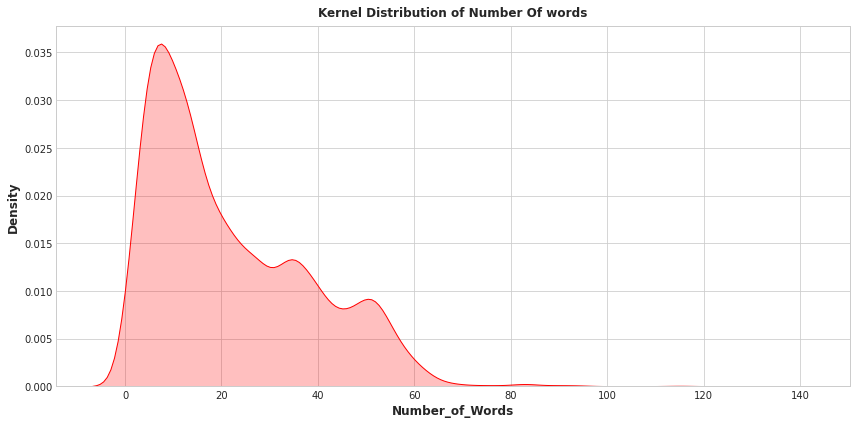

In [13]:
# to have an overview of the data
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['Number_of_Words'], fill=True, color="r").set_title('Kernel Distribution of Number Of words')

In [14]:
df['Number_of_Words'].describe()

count    10758.000000
mean        21.867076
std         16.658578
min          1.000000
25%          8.000000
50%         17.000000
75%         34.000000
max        135.000000
Name: Number_of_Words, dtype: float64

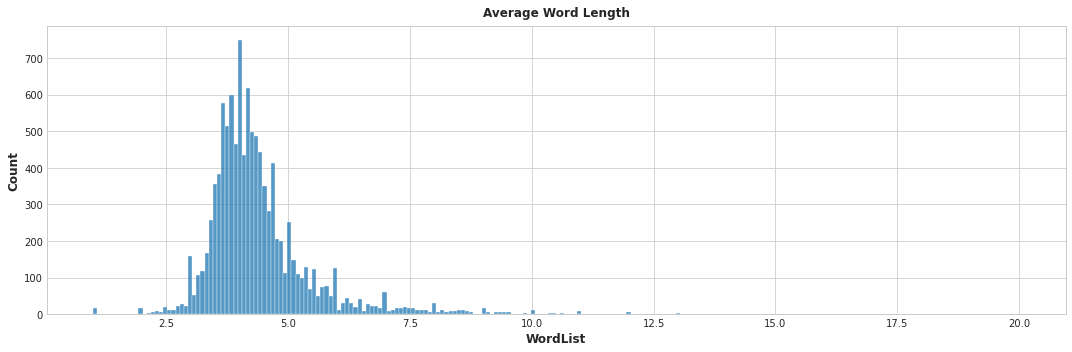

In [15]:
#compute the average length of words for each tweet
mean_word_len = df['WordList'].apply(lambda x : np.mean([len(i) for i in x]))
#plot the distribution of the average length of words
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=mean_word_len)
plt.title("Average Word Length")
plt.show()

In [16]:
top = Counter([item for sublist in df['WordList'] for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,to,4929
1,the,4850
2,I,3944
3,and,3522
4,a,3344
5,is,2635
6,in,2364
7,of,2256
8,for,2187
9,it,2155


In [17]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

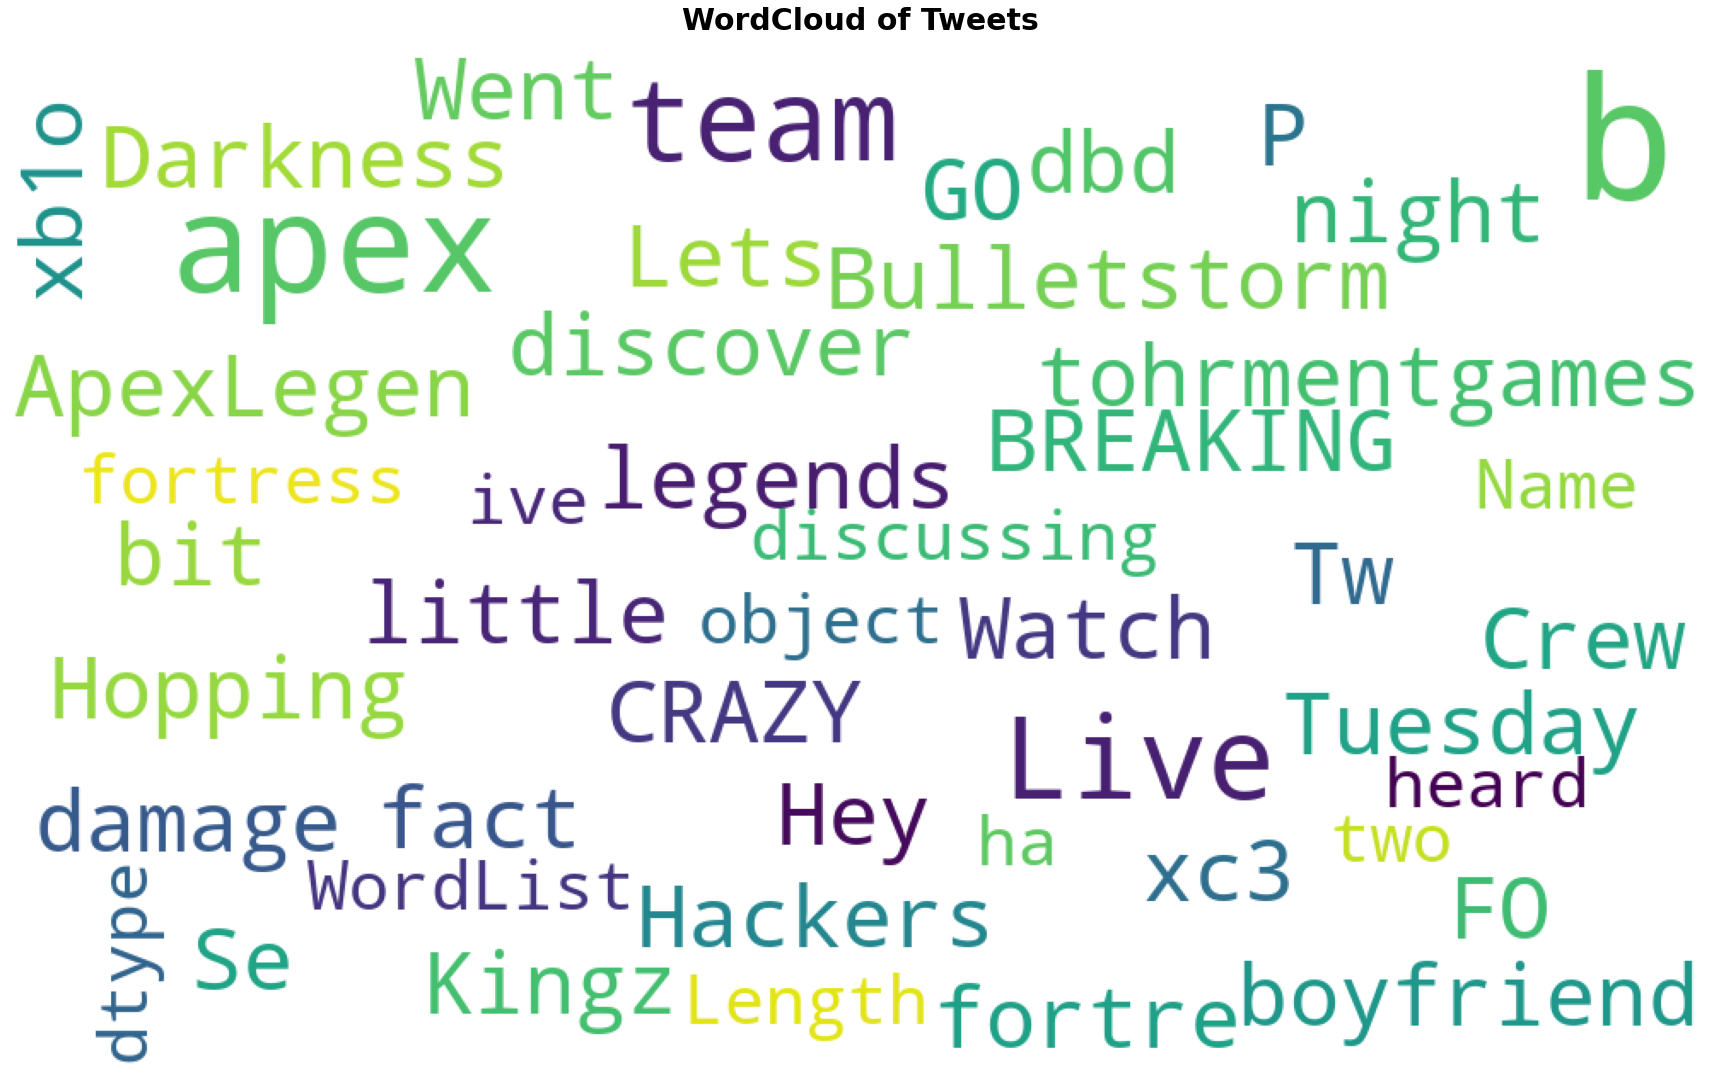

In [18]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(df['WordList'], mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Tweets")

<a id="2"></a>
    
[<font size="+2" color="indigo"><b>2. Lexicon based Methods</b></font><br>](#0)

#### There are primarily 3 ways for lexicon based sentiment analysis:
#### 1) Rule-based methods

Rule based are the methods which involve set of manually crafted rules to identify subjectivity, polarity, or the subject of an opinion. These involve techniques like Stemming, tokenization, part-of-speech tagging, parsing, Lexicons (i.e. lists of words and expressions). 


Generally, two lists of polarized words (e.g. negative words such as bad, worst, ugly, etc and positive words such as good, best, beautiful, etc) are prepared. The number of positive and negative words that appear in a given text are counted. If the number of positive word appearances is greater than the number of negative word appearances, the system returns a positive sentiment, and vice versa. If the numbers are even, the system will return a neutral sentiment. Methods involve
[AFINN](https://github.com/fnielsen/afinn), [Bing Liu's lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), [MPQA subjectivity lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/), [SentiWordNet](http://sentiwordnet.isti.cnr.it/http://), [TextBlob](https://textblob.readthedocs.io/en/dev/) & [VADER](https://github.com/cjhutto/vaderSentiment)


#### 2) Feature-based methods


Since rule-based are generally naive in nature as don't take into account how words are combined in a sequence. Hence, feature-based methods relying on ML techniques like SVM, Decision trees, etc. are used where sentiment analysis is modeled as a classification problem. The first step in a machine learning text classifier is to transform the text extraction or text vectorization, and the classical approach has been bag-of-words or bag-of-ngrams with their frequency. More recently, new feature extraction techniques have been applied based on word embeddings (also known as word vectors). This kind of representations makes it possible for words with similar meaning to have a similar representation, which can improve the performance of classifiers.



#### 3) Embedding-based methods
Last is embedding based which involve [FastText](https://fasttext.cc/docs/en/supervised-tutorial.html) & [Flair](https://github.com/flairNLP/flair/)

<a id="2.1"></a>
    
[<font size="+1" color="indigo"><b>2.1 VADER Sentiment Analysis</b></font><br>](#0)


Valence Aware Dictionary and sEntiment Reasoner is a lexicon and rule based sentiment analysis tool which works very well on social media sentiments. It is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It can be applied directly to unlabeled text data.

In [19]:
analyser = SentimentIntensityAnalyzer()  # imported from nltk package

In [20]:
# Using polarity scores for knowing the polarity of each text
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    return ("{:-<40} {}".format(sentence, str(score)))

In [21]:
#testing the function
tweet  = "I would love to watch the magic show again"
tweet2 = "What the hell they have made. Pathetic!"
tweet3 = " I do not know what to do"  
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

I would love to watch the magic show again {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}
What the hell they have made. Pathetic!- {'neg': 0.632, 'neu': 0.368, 'pos': 0.0, 'compound': -0.8622}
 I do not know what to do--------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Here compound score is what reflects the overall score. It is sum of all lexicon ratings which is normalized between -1 (most extreme negative) and +1 (most extreme poistive). As per the scoring document ([link](https://github.com/cjhutto/vaderSentiment#about-the-scoring)) it is called as 'normalized, weighted composite score.'


The typical thresholds standardized for classifying sentences as positve, negative, neutral are: 
1. positive sentiment: compound score >= 0.05
2. neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
3. negative sentiment: compound score <= -0.05  
However, they can be adjusted for highly positive, positive, neutral, negative and highly negative classes as per the requirements.

#### Like other preprocessing in text analysis we are not required to remove emojis, slangs (abbreviations), emoticons, punctuations, etc. as VADER generates scores based on these. 
#### Some of the examples are:


#### 1) Upper Case (Capitalization)
Use of upper case alphabets/words indicate the increase in magnitude of the sentiment. For example, I like the fact that monsoon is over. vs I LIKE the fact that monsoon is over.

In [22]:
tweet  = "I like the fact that monsoon is over"
tweet2 = "I LIKE the fact that monsoon is over"

In [23]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))

I like the fact that monsoon is over---- {'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.3612}
I LIKE the fact that monsoon is over---- {'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compound': 0.4995}


#### The compound score increases by 13% just by capitalization

#### 2) Punctuation
Use of punctuation like !, ?, etc. add to the intensity of the text.

In [24]:
tweet  = "What is wrong with you"
tweet2  = "What is wrong with you?"
tweet3 = "What is wrong with you??"

In [25]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

What is wrong with you------------------ {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767}
What is wrong with you?----------------- {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767}
What is wrong with you??---------------- {'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.5362}


#### 3) Conjuctions
Conjuctions lead to shift in polarity. The latter part (after the conjuction) acts as dominant part in defining the magnitude of polarity.

In [26]:
tweet  = "He is good but his mother is irritating"
tweet2 = "The thai curry was bad, however pasta was delicious"
tweet3 = "The thai curry was ok and pasta was delicious"

In [27]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

He is good but his mother is irritating- {'neg': 0.335, 'neu': 0.502, 'pos': 0.163, 'compound': -0.4678}
The thai curry was bad, however pasta was delicious {'neg': 0.246, 'neu': 0.493, 'pos': 0.261, 'compound': 0.0516}
The thai curry was ok and pasta was delicious {'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'compound': 0.7096}


#### 4) Degree modifiers
As the name suggests they intensify the degree in positive or negative manner as per the use.

In [28]:
tweet = "Real Madrid's game play was good last night."
tweet2 = "Real Madrid's game play was extremely good last night."
tweet3 = "Real Madrid's game play was somewhat good last night."
tweet4 = "Real Madrid's game play was terrible last night."
tweet5 = "Real Madrid's game play was awfully terrible last night."

In [29]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))
print (sentiment_analyzer_score(tweet4))
print (sentiment_analyzer_score(tweet5))

Real Madrid's game play was good last night. {'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.6486}
Real Madrid's game play was extremely good last night. {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.6801}
Real Madrid's game play was somewhat good last night. {'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'compound': 0.6133}
Real Madrid's game play was terrible last night. {'neg': 0.27, 'neu': 0.522, 'pos': 0.209, 'compound': -0.1779}
Real Madrid's game play was awfully terrible last night. {'neg': 0.265, 'neu': 0.547, 'pos': 0.188, 'compound': -0.2484}


#### 5) Use of emoticons

In [30]:
tweet = " What a fine day I am having today"
tweet2 = " What a fine day I am having today :-)"
tweet3 = " What a fine day I am having today :-) :-)"

In [31]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

 What a fine day I am having today------ {'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'compound': 0.2023}
 What a fine day I am having today :-)-- {'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.4767}
 What a fine day I am having today :-) :-) {'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.6597}


#### 6) Use of emojis (utf-8 encoded)

In [32]:
tweet = "I love the team and how they played last night"
tweet2 = "I love the team and how they played last night 💘"
tweet3 = "I love the team and how they played last night 😁"

In [33]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

I love the team and how they played last night {'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'compound': 0.765}
I love the team and how they played last night 💘 {'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'compound': 0.765}
I love the team and how they played last night 😁 {'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'compound': 0.765}


#### 7) Slangs 

In [34]:
tweet = "I am laughing like crazy"
tweet2 = "I am laughing like crazy lmao"
tweet3 = "I am laughing like crazy lol"

In [35]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))
print (sentiment_analyzer_score(tweet3))

I am laughing like crazy---------------- {'neg': 0.264, 'neu': 0.11, 'pos': 0.626, 'compound': 0.5106}
I am laughing like crazy lmao----------- {'neg': 0.185, 'neu': 0.077, 'pos': 0.738, 'compound': 0.802}
I am laughing like crazy lol------------ {'neg': 0.202, 'neu': 0.084, 'pos': 0.714, 'compound': 0.7269}


#### 8) Use of negations 

In [36]:
tweet = "He wasn't very good at the play"
tweet2 = "He was not very good at the play"

In [37]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))

He wasn't very good at the play--------- {'neg': 0.262, 'neu': 0.499, 'pos': 0.239, 'compound': -0.0574}
He was not very good at the play-------- {'neg': 0.238, 'neu': 0.544, 'pos': 0.218, 'compound': -0.0574}


#### 9) Slang words as modifiers

In [38]:
tweet = "He is kinda bored"
tweet2 = "He is friggin bored"

In [39]:
print (sentiment_analyzer_score(tweet))
print (sentiment_analyzer_score(tweet2))

He is kinda bored----------------------- {'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'compound': -0.204}
He is friggin bored--------------------- {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.3384}


<a id="2.2"></a>
    
[<font size="+1" color="indigo"><b>2.2. Model</b></font><br>](#0)

Now we can train models applying vadar


In [40]:
df['scores'] = df['ProcessedText'].apply(lambda review: analyser.polarity_scores(review))
df.head()

,Text,Subjectivity,Polarity,ProcessedText,WordList,Number_of_Words,scores
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,Hey Kingz Crew I Just Went Live On Twitch Come...,"[Hey, Kingz, Crew, I, Just, Went, Live, On, Tw...",17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,little bit of dbd into apex legends (: https:/...,0.0,NaN,little bit of dbd into apex legends (:,"[little, bit, of, dbd, into, apex, legends]",7,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp..."
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,Tuesday night apex?! Lets get some damage! #ap...,"[Tuesday, night, apex, Lets, get, some, damage...",12,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp..."
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,"[Watch, tohrmentgames, GO, CRAZY, ON, APEX, FO...",9,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp..."
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,3...2...1.. LIVE! Hopping into some #ApexLegen...,"[3, 2, 1, LIVE, Hopping, into, some, ApexLegen...",25,"{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp..."


In [41]:
if 'neg' in df.columns:
    df = df.drop(columns={'neg', 'neu', 'pos', 'compound'}, errors='ignore')
df = df.join(df['scores'].apply(pd.Series))
df.head()

,Text,Subjectivity,Polarity,ProcessedText,WordList,Number_of_Words,scores,neg,neu,pos,compound
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,Hey Kingz Crew I Just Went Live On Twitch Come...,"[Hey, Kingz, Crew, I, Just, Went, Live, On, Tw...",17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,little bit of dbd into apex legends (: https:/...,0.0,NaN,little bit of dbd into apex legends (:,"[little, bit, of, dbd, into, apex, legends]",7,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.000,0.686,0.314,0.4939
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,Tuesday night apex?! Lets get some damage! #ap...,"[Tuesday, night, apex, Lets, get, some, damage...",12,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp...",0.256,0.744,0.000,-0.5837
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,"[Watch, tohrmentgames, GO, CRAZY, ON, APEX, FO...",9,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp...",0.334,0.666,0.000,-0.6135
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,3...2...1.. LIVE! Hopping into some #ApexLegen...,"[3, 2, 1, LIVE, Hopping, into, some, ApexLegen...",25,"{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...",0.000,0.906,0.094,0.2905


<a id="2.3"></a>
[<font size="+1" color="indigo"><b>2.3. Model Evaluation</b></font><br>](#0)

using simple bar plots to show the result of prediction<br>
then use confusion matrix to find the score with labeled data

In [42]:
def Subjectivity(x):
    if x>= 0.05 or x<= -0.05:
        return 1  # positive or negative
    else:
        return 0  # neutrual
    
def Polarity(x):
    if x>= 0.05:
        return 1  # positive
    elif x<= -0.05:
        return 0  # negative
    else:
        return None
    
#df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
df['PredSubjectivity'] = df['compound'].apply(Subjectivity)
df['PredPolarity'] = df['compound'].apply(Polarity)

df.head()

,Text,Subjectivity,Polarity,ProcessedText,WordList,Number_of_Words,scores,neg,neu,pos,compound,PredSubjectivity,PredPolarity
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,Hey Kingz Crew I Just Went Live On Twitch Come...,"[Hey, Kingz, Crew, I, Just, Went, Live, On, Tw...",17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0,NaN
1,little bit of dbd into apex legends (: https:/...,0.0,NaN,little bit of dbd into apex legends (:,"[little, bit, of, dbd, into, apex, legends]",7,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.000,0.686,0.314,0.4939,1,1.0
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,Tuesday night apex?! Lets get some damage! #ap...,"[Tuesday, night, apex, Lets, get, some, damage...",12,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp...",0.256,0.744,0.000,-0.5837,1,0.0
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,"[Watch, tohrmentgames, GO, CRAZY, ON, APEX, FO...",9,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp...",0.334,0.666,0.000,-0.6135,1,0.0
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,3...2...1.. LIVE! Hopping into some #ApexLegen...,"[3, 2, 1, LIVE, Hopping, into, some, ApexLegen...",25,"{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...",0.000,0.906,0.094,0.2905,1,1.0


In [43]:
test_df = df[df['Subjectivity'].notna()].copy()

In [44]:
def bar_plot(col:str):
    plt.figure(figsize=(12,6))
    sns.countplot(x=col,data=df)

In [45]:
def basic_plot(col:str):
    bar_plot(col)
    var1 = df.groupby(col).count()['Text'].reset_index().sort_values(by='Text',ascending=False)
    sns.set_style("white")
    sns.set_palette("Set2")
    return var1.style.background_gradient()

In [46]:
def plot_confusion_mtx(col:str, pred_col:str, test_df:pd.DataFrame):
    # confusion matrix
    test_df=test_df[[col, pred_col]].fillna(2)
    cf = confusion_matrix(test_df[col], test_df[pred_col])
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    sns.heatmap(cf, annot=box_labels, fmt='')
    print(classification_report(test_df[col], test_df[pred_col]))

,PredSubjectivity,Text
1,1,7244
0,0,3514


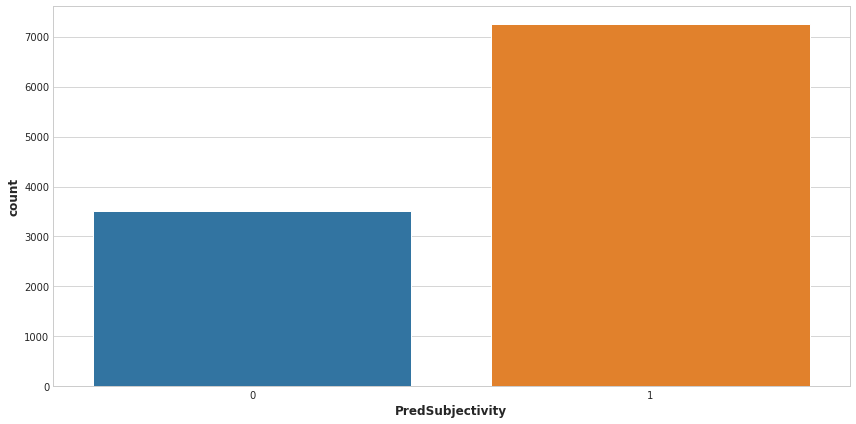

In [47]:
basic_plot('PredSubjectivity')

              precision    recall  f1-score   support

         0.0       0.74      0.33      0.46       496
         1.0       0.61      0.90      0.72       565

    accuracy                           0.64      1061
   macro avg       0.68      0.62      0.59      1061
weighted avg       0.67      0.64      0.60      1061



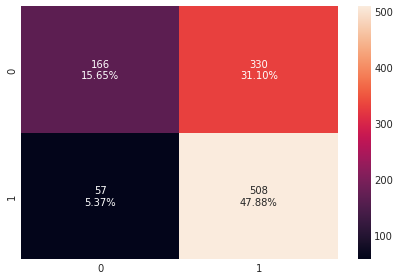

In [48]:
plot_confusion_mtx('Subjectivity', 'PredSubjectivity', test_df)

,PredPolarity,Text
1,1.000000,4633
0,0.000000,2611


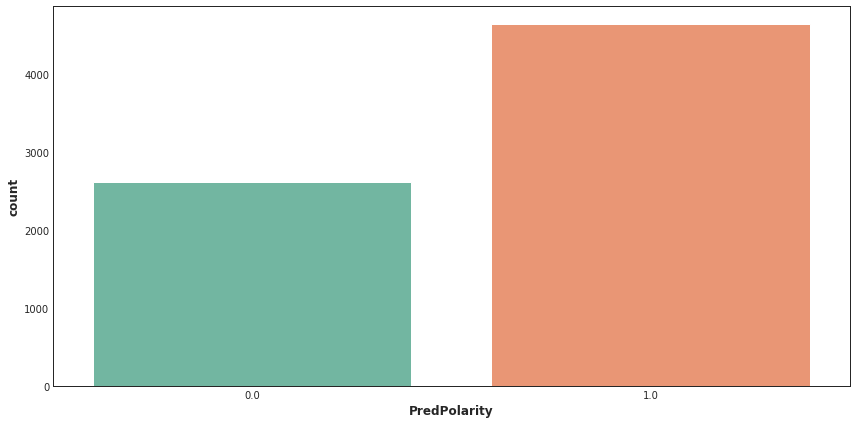

In [49]:
basic_plot('PredPolarity')

              precision    recall  f1-score   support

         0.0       0.55      0.64      0.59       283
         1.0       0.41      0.76      0.53       276
         2.0       0.85      0.38      0.52       502

    accuracy                           0.55      1061
   macro avg       0.60      0.59      0.55      1061
weighted avg       0.66      0.55      0.54      1061



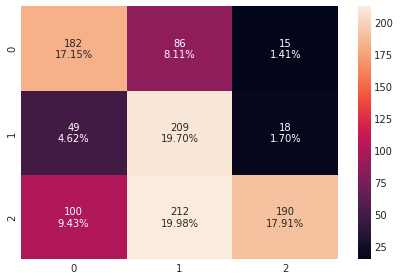

In [50]:
plot_confusion_mtx('Polarity', 'PredPolarity', test_df)

# TODO (sort by priority):
1. confusion matrix for polarity (15mins) &check;
2. TextBlob Model (30mins) &check;
3. Bert (3hrs)
4. Compare results & export better model, encapsulate as API (2hrs)
5. Advanced Emotion Analysis (3hrs)


<a id="3"></a>
    
[<font size="+2" color="indigo"><b>3. TextBlob Model</b></font><br>](#0)

<a id="3.1"></a>
    
[<font size="+1" color="indigo"><b>3.1. Fitting Model</b></font><br>](#0)

In [51]:
tweet = "I would love to watch the magic show again!!!"
TextBlob(tweet).sentiment

Sentiment(polarity=0.73828125, subjectivity=0.8)

1. Polarity is of 'float' type and lies in the range of -1,1, where 1 means a high positive sentiment, and -1 means a high negative sentiment.

2. Subjectivity is also of 'float' type and lies in the range of 0,1. The value closer to 1 indicates that the sentence is mostly a public opinion and not a factual piece of information and vice versa. 

In [52]:
# Applying on dataset
df['TB_score']= df.ProcessedText.apply(lambda x: TextBlob(x).sentiment)
df.head()

,Text,Subjectivity,Polarity,ProcessedText,WordList,Number_of_Words,scores,neg,neu,pos,compound,PredSubjectivity,PredPolarity,TB_score
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,Hey Kingz Crew I Just Went Live On Twitch Come...,"[Hey, Kingz, Crew, I, Just, Went, Live, On, Tw...",17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0,NaN,"(0.17045454545454544, 0.5)"
1,little bit of dbd into apex legends (: https:/...,0.0,NaN,little bit of dbd into apex legends (:,"[little, bit, of, dbd, into, apex, legends]",7,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.000,0.686,0.314,0.4939,1,1.0,"(-0.1875, 0.5)"
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,Tuesday night apex?! Lets get some damage! #ap...,"[Tuesday, night, apex, Lets, get, some, damage...",12,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp...",0.256,0.744,0.000,-0.5837,1,0.0,"(0.0, 0.0)"
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,"[Watch, tohrmentgames, GO, CRAZY, ON, APEX, FO...",9,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp...",0.334,0.666,0.000,-0.6135,1,0.0,"(-1.0, 0.9)"
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,3...2...1.. LIVE! Hopping into some #ApexLegen...,"[3, 2, 1, LIVE, Hopping, into, some, ApexLegen...",25,"{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...",0.000,0.906,0.094,0.2905,1,1.0,"(0.21070075757575757, 0.5833333333333333)"


<a id="3.2"></a>
    
[<font size="+1" color="indigo"><b>3.2. Model Evaluation</b></font><br>](#0)

In [53]:
def TBPolarity(x):
    if x[0]>0.2:
        return 1  # consider positive
    elif x[0]<-0.2:
        return 0  # consider negative
    else:
        return None
    
def TBSubjectivity(x):
    if x[1]>0.5:
        return 1 # consider opinionated
    else:
        return 0 # consider factual

In [54]:
if 'TB_PredPolarity' in df.columns:
    df = df.drop(columns={'TB_PredPolarity', 'TB_PredSubjectivity'}, errors='ignore')
df['TB_PredSubjectivity'] = df['TB_score'].apply(TBSubjectivity)
df['TB_PredPolarity'] = df['TB_score'].apply(TBPolarity)
df[df['TB_PredSubjectivity'] == 0]['TB_PredPolarity'] = np.nan
df.head()

,Text,Subjectivity,Polarity,ProcessedText,WordList,Number_of_Words,scores,neg,neu,pos,compound,PredSubjectivity,PredPolarity,TB_score,TB_PredSubjectivity,TB_PredPolarity
0,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,Hey Kingz Crew I Just Went Live On Twitch Come...,"[Hey, Kingz, Crew, I, Just, Went, Live, On, Tw...",17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0,NaN,"(0.17045454545454544, 0.5)",0,NaN
1,little bit of dbd into apex legends (: https:/...,0.0,NaN,little bit of dbd into apex legends (:,"[little, bit, of, dbd, into, apex, legends]",7,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.000,0.686,0.314,0.4939,1,1.0,"(-0.1875, 0.5)",0,NaN
2,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,Tuesday night apex?! Lets get some damage! #ap...,"[Tuesday, night, apex, Lets, get, some, damage...",12,"{'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'comp...",0.256,0.744,0.000,-0.5837,1,0.0,"(0.0, 0.0)",0,NaN
3,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,"[Watch, tohrmentgames, GO, CRAZY, ON, APEX, FO...",9,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp...",0.334,0.666,0.000,-0.6135,1,0.0,"(-1.0, 0.9)",1,0.0
4,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,3...2...1.. LIVE! Hopping into some #ApexLegen...,"[3, 2, 1, LIVE, Hopping, into, some, ApexLegen...",25,"{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...",0.000,0.906,0.094,0.2905,1,1.0,"(0.21070075757575757, 0.5833333333333333)",1,1.0


In [55]:
tb_test_df = df[df['Subjectivity'].notna()].copy()

,TB_PredSubjectivity,Text
0,0,7096
1,1,3662


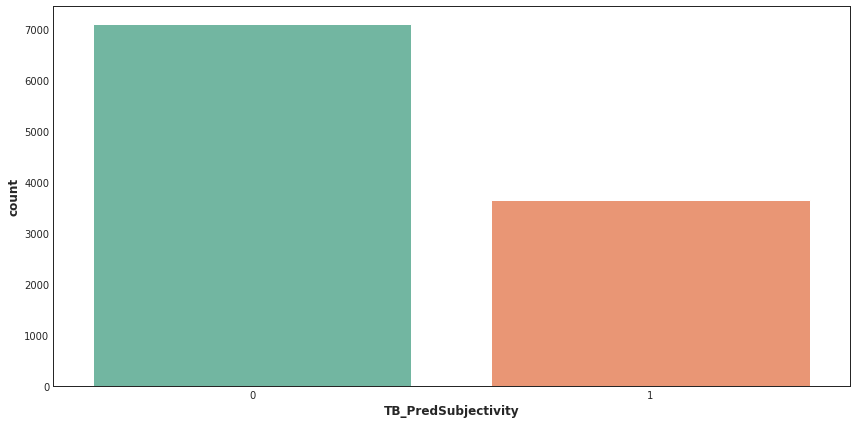

In [56]:
basic_plot('TB_PredSubjectivity')

              precision    recall  f1-score   support

         0.0       0.59      0.38      0.46       283
         1.0       0.43      0.41      0.42       276
         2.0       0.52      0.64      0.57       502

    accuracy                           0.51      1061
   macro avg       0.51      0.47      0.48      1061
weighted avg       0.51      0.51      0.50      1061



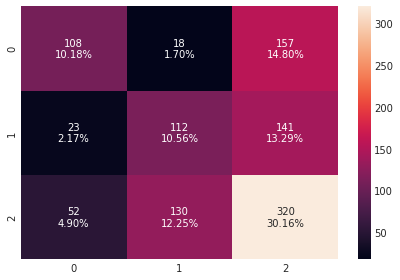

In [57]:
plot_confusion_mtx('Polarity', 'TB_PredPolarity', tb_test_df)

,TB_PredPolarity,Text
1,1.000000,2688
0,0.000000,1316


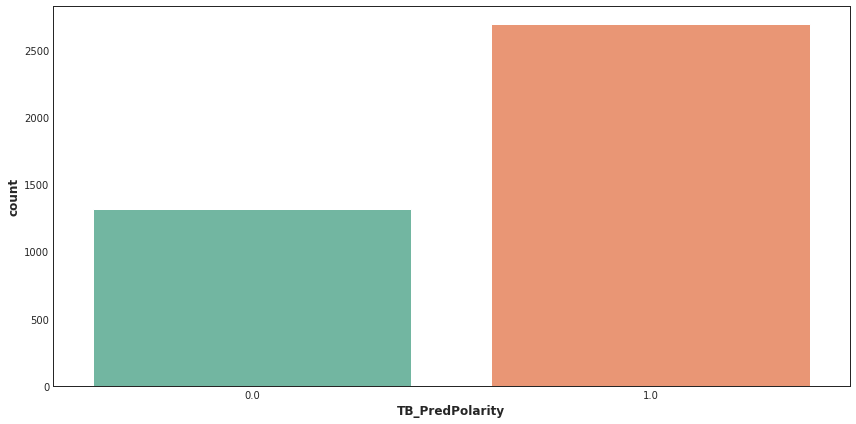

In [58]:
basic_plot('TB_PredPolarity')

              precision    recall  f1-score   support

         0.0       0.59      0.38      0.46       283
         1.0       0.43      0.41      0.42       276
         2.0       0.52      0.64      0.57       502

    accuracy                           0.51      1061
   macro avg       0.51      0.47      0.48      1061
weighted avg       0.51      0.51      0.50      1061



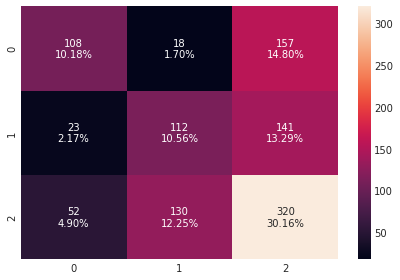

In [59]:
plot_confusion_mtx('Polarity', 'TB_PredPolarity', tb_test_df)

<a id="4"></a>
    
[<font size="+2" color="indigo"><b>4. Bert</b></font><br>](#0)

As Bert is commonly used pretrained model without social media specific tweaking, it's performance would be better if we can fine-tune the Bert with publicly available labeled twitter datasets.

<a id="4.1"></a>
    
[<font size="+1" color="indigo"><b>4.1. loading and cleaning training data</b></font><br>](#0)

In [60]:
# loading training data

df = pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv',
                 encoding='ISO-8859-1', header=None)
df.columns = ['tweet_id','entity','sentiment','content']
df_test = pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_validation.csv',
                     encoding='ISO-8859-1', header=None)
df_test.columns = ['tweet_id','entity','sentiment','content']

In [61]:
df.head()

,tweet_id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


we can see that the tweet_id is repeated and content is very similar. we should clean the dataset by keeping only the first occurance

In [62]:
df = df.drop_duplicates(keep='first', subset=['tweet_id'])
df_test = df_test.drop_duplicates(keep='first', subset=['tweet_id'])

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12447 entries, 0 to 74676
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   12447 non-null  int64 
 1   entity     12447 non-null  object
 2   sentiment  12447 non-null  object
 3   content    12447 non-null  object
dtypes: int64(1), object(3)
memory usage: 486.2+ KB


In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


##### cleaning data with similar preprocessing steps for tweets

In [65]:
df = df[['sentiment','content']]
df_test = df_test[['sentiment','content']]

In [66]:
df['text_clean'] = df['content'].apply(tweet_clean)
df_test['text_clean'] = df['content'].apply(tweet_clean)
df = df.dropna(subset=['text_clean'])
df_test = df_test.dropna(subset=['text_clean'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12447 entries, 0 to 74676
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   12447 non-null  object
 1   content     12447 non-null  object
 2   text_clean  12447 non-null  object
dtypes: object(3)
memory usage: 389.0+ KB


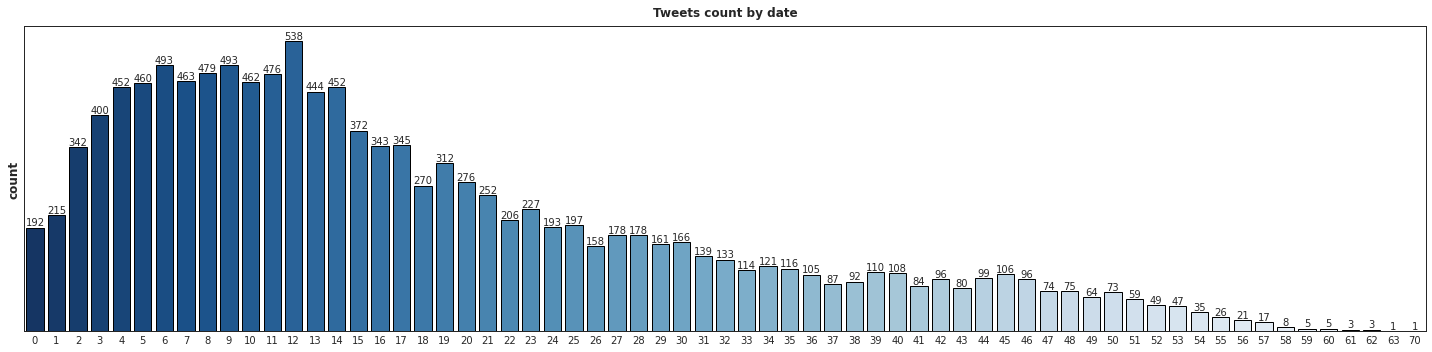

In [67]:
# to gain more insights into the dataset, we should look at text word count
df['word_cnt'] = df['text_clean'].apply(lambda x: len(x.split()))
df_test['word_cnt'] = df_test['text_clean'].apply(lambda x: len(x.split()))
word_counts = df['word_cnt'].value_counts().reset_index(name='word_counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='word_counts', data=word_counts, edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [68]:
df = df[df['word_cnt']>4].copy()
df_test = df_test[df_test['word_cnt']>4].copy()

<b>Training data deeper learning</b>

In [69]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [77]:
df['token_lens'] = df['text_clean'].apply(lambda x:len(tokenizer.encode(x, max_length=512, truncation=True)))
df_test['token_lens'] = df_test['text_clean'].apply(lambda x:len(tokenizer.encode(x, max_length=512, truncation=True)))

In [79]:
df = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

<a id="advanced"></a>
    
[<font size="+2" color="indigo"><b>Advanced: Emotions in Text</b></font><br>](#0)

### Getting emotions using NCR Emotion lexicon
[Link](https://pypi.org/project/NRCLex/)

In [70]:
!pip install nrclex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=49d74b2bd0dd4e06b6f4348e703fc2bb1678ec1ba2d7b77b0bdde158ac556a03
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [71]:
from nrclex import NRCLex

In [72]:
tweet = NRCLex('Good work to the team')
#Return affect dictionary
print(tweet.affect_dict)
#Return raw emotional counts
print("\n",tweet.raw_emotion_scores)
#Return highest emotions
print("\n", tweet.top_emotions)
#Return affect frequencies
print("\n",tweet.affect_frequencies)

{'team': ['trust']}

 {'trust': 1}

 [('trust', 1.0)]

 {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 1.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.0, 'sadness': 0.0, 'disgust': 0.0, 'joy': 0.0}


In [73]:
Text = NRCLex("Congratulations ")
# Getting top emotions
print("\n", Text.top_emotions)
# Getting the top most emotion
print("\n", Text.top_emotions[0][0])
# Getting the top most emotion score
print("\n", Text.top_emotions[0][1])


 [('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]

 fear

 0.0


In [74]:
Text = NRCLex("We can do it ")
# Getting top emotions
print("\n", Text.top_emotions)
# Getting the top most emotion
print("\n", Text.top_emotions[0][0])
# Getting the top most emotion score
print("\n", Text.top_emotions[0][1])


 [('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]

 fear

 0.0


In [75]:
def emotion(x):
    Text = NRCLex(x)
    if Text.top_emotions[0][1] == 0.0:
        return "No emotion"
    else:
        return Text.top_emotions[0][0]
df['Emotion'] = df['Text'].apply(emotion)
df.head()

KeyError: 'Text'

In [ ]:

import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

df_chart = df[df.Emotion != "No emotion"]
labels = df_chart.Emotion.value_counts().index.tolist()
data = df_chart.Emotion.value_counts()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

In [ ]:
b = df_chart.Emotion.value_counts().index.tolist()
a = df_chart.Emotion.value_counts(normalize = True).tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Emotions')
fig.show()

There are many other Emotion Lexicons like [EmoWordNet](https://www.aclweb.org/anthology/S18-2009.pdf), [EmoTxt](https://arxiv.org/ftp/arxiv/papers/1708/1708.03892.pdf) & [DepecheMood++](https://arxiv.org/pdf/1810.03660v1.pdf) which can be looked into.


## Future work: 
   1) Working on other (richer) emotion lexicons \
   2) Lexicon based models vs ML models vs Deep Learning Models 
